# Fashion MNIST Analysis

This notebook explores the different algorithms that can be applied to the dataset fashion MNIST

In [2]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.datasets import fashion_mnist

config = {
    "batch": 32,
    'epochs': 10
}

2024-06-06 20:18:53.929724: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Loading the dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [4]:
# Understand the size of this dataset
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


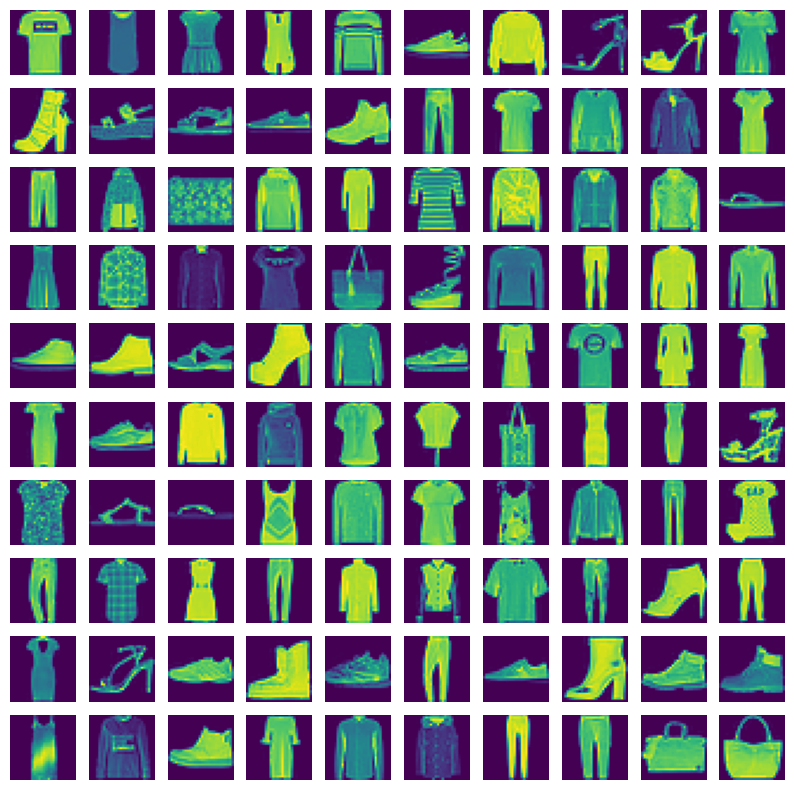

In [5]:
# Plot a sample of this dataset
plt.figure(figsize=(10,10))
for i in range(1,101):
    plt.subplot(10, 10, i)
    plt.imshow(X_train[i])
    plt.axis('off')

plt.show()

Text(-3.9305555555555554, 0.5, 'Label Count')

<Figure size 2000x500 with 0 Axes>

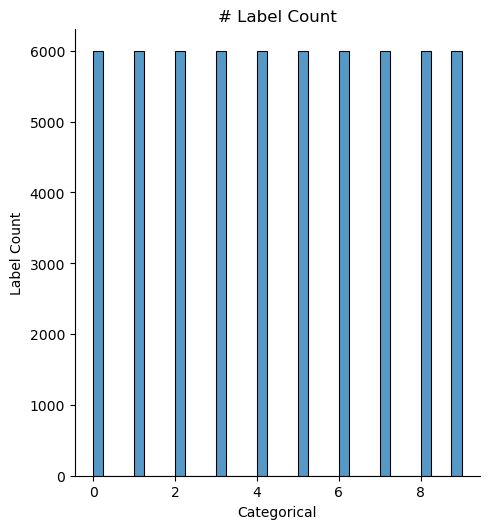

In [6]:
plt.figure(figsize=(20, 5))
sns.displot(y_train)
plt.title("# Label Count")
plt.xlabel("Categorical")
plt.ylabel("Label Count")

# 1. Create the CNN model

In this case, we will create a 2 stage CNN model, with 2 additional dense layers at the end. 

In [6]:
# Create the 2D CNN
SimpleCNN_model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
SimpleCNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0

2024-06-06 19:52:25.776664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# Compile the model 
# Use sparse categorial cross-entropy
SimpleCNN_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

# Fit the model
SimpleCNN_model.fit(X_train, y_train, 
                    epochs=config['epochs'], batch_size=config['batch'])

Epoch 1/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.4448 - accuracy: 0.8388
Epoch 2/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.2964 - accuracy: 0.8911
Epoch 3/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.2515 - accuracy: 0.9077
Epoch 4/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2207 - accuracy: 0.9181
Epoch 5/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.1964 - accuracy: 0.9266
Epoch 6/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.1729 - accuracy: 0.9346
Epoch 7/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1528 - accuracy: 0.9420
Epoch 8/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.1363 - accuracy: 0.9481
Epoch 9/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1186 - accuracy: 0.9546
Epoch 10/10
1875/1875 [==============================] - 30s 16m

In [8]:
loss, accuracy = SimpleCNN_model.evaluate(X_test, y_test)
print(f"Accuracy on the test set -> {accuracy}")

313/313 [==============================] - 3s 7ms/step - loss: 0.2903 - accuracy: 0.9091
Accuracy on the test set -> 0.9090999960899353


# 2. Explore latent space using an AutoEncoder

In [26]:
def preprocess_input(imgs):
    imgs = imgs.astype('float32') / 255.0
    imgs = np.pad(imgs, ((0,0), (2,2), (2,2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

In [27]:
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [29]:
# Create the encoder part of the model
encoder_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), strides=2, activation='relu', padding='same', input_shape=(32, 32, 1)),
  tf.keras.layers.Conv2D(64, (3, 3), strides=2, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(128, (3, 3), strides=2, activation='relu', padding='same'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2, name='encoder_output'),
])
encoder_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 16, 16, 32)        320       
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 conv2d_12 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96,770
Trainable params: 96,770
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Create the decoder part of the model
decoder_model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(2, ), name="decoder_input"),
  tf.keras.layers.Dense(2048),
  tf.keras.layers.Reshape((4, 4, 128)),
  tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same'),
  tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same'),
  tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(1, (3,3), strides=1, activation='sigmoid', padding='same'),
])
decoder_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 2048)              6144      
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 8, 8, 128)        147584    
 ranspose)                                                       
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 16, 16, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 32, 32, 32)       18464     
 ranspose)                                                       
                                                      

In [31]:
# Put all the models together
autoencoder = tf.keras.Sequential([
    encoder_model,
    decoder_model
])
autoencoder.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 2)                 96770     
                                                                 
 sequential_8 (Sequential)   (None, 32, 32, 1)         246273    
                                                                 
Total params: 343,043
Trainable params: 343,043
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Compile model
autoencoder.compile(
    optimizer="adam", 
    loss='binary_crossentropy', # I would use RMSE, but the book uses binary crossentropy
)
autoencoder.fit(
    x=X_train, 
    y=X_train, 
    epochs=5, 
    batch_size=32, 
    shuffle=True, 
    validation_data=(X_test, X_test)
)

Epoch 1/5


1875/1875 [==============================] - 82s 43ms/step - loss: 0.2536 - val_loss: 0.2533
Epoch 2/5
1875/1875 [==============================] - 82s 44ms/step - loss: 0.2507 - val_loss: 0.2516
Epoch 3/5
1875/1875 [==============================] - 84s 45ms/step - loss: 0.2490 - val_loss: 0.2493
Epoch 4/5
1875/1875 [==============================] - 85s 45ms/step - loss: 0.2477 - val_loss: 0.2491
Epoch 5/5
1875/1875 [==============================] - 82s 44ms/step - loss: 0.2469 - val_loss: 0.2483


313/313 [==============================] - 6s 17ms/step


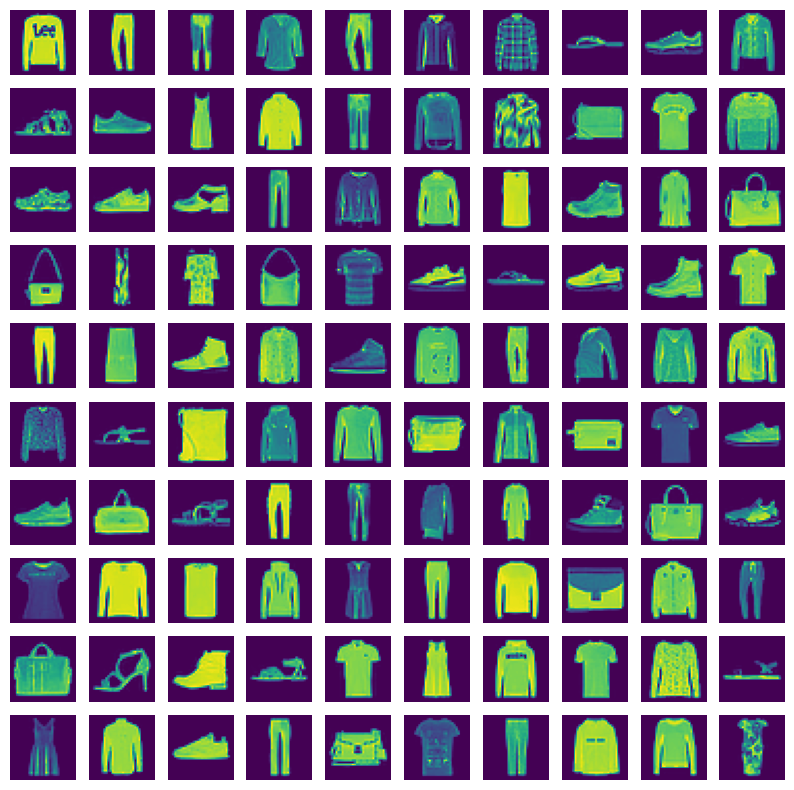

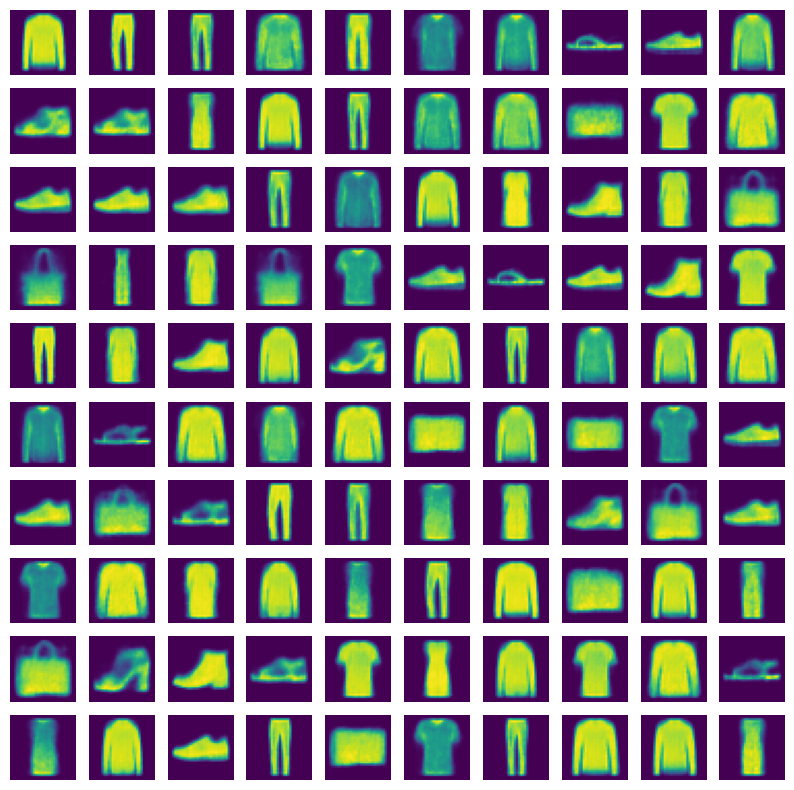

In [42]:
# Perform predictions
X_test_pred = autoencoder.predict(X_test)

# Plot a sample of this dataset
plt.figure(figsize=(10,10))
for i in range(1,101):
    plt.subplot(10, 10, i)
    plt.imshow(X_test[i])
    plt.axis('off')

plt.show()

# Plot the reconstructed version of this dataset
plt.figure(figsize=(10,10))
for i in range(1,101):
    plt.subplot(10, 10, i)
    plt.imshow(X_test_pred[i])
    plt.axis('off')

plt.show()

  1/313 [..............................] - ETA: 11s

313/313 [==============================] - 2s 5ms/step


<Axes: xlabel='Dim1', ylabel='Dim2'>

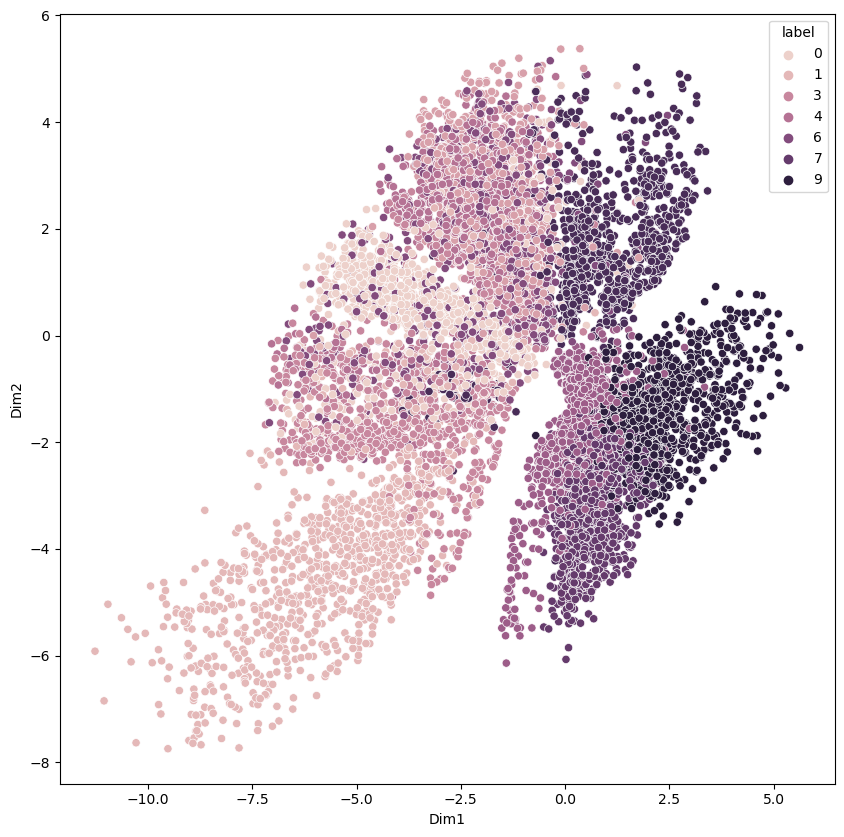

In [43]:
# Plot the latent space
# 1- Obtain embeddings
df_embeddings = pd.DataFrame(encoder_model.predict(X_test), columns = ("Dim1", "Dim2"))
df_embeddings['label'] = y_test

# 2- Plot embedding space
plt.figure(figsize=(10,10))
sns.scatterplot(data=df_embeddings, x='Dim1', y='Dim2', hue='label')


# 3. Enhancing the latent space using Variational Autoencoders (VAE)

The previous latent space has some issues:
- The distribution of the different labels is not uniform in the latent space. Hence, if we sample the latent space, the probability distribution would be asymmentrical to for the different classes.
- There are holes in the latent space that don't really generate anything recognizable.

To solve this, we turn to Variational Autoencoders, or VAE.

(This doesn't seem relevant to me, skipping)